# Numerical Derjaguin model with full protein structure

v2:  Proof-of-concept, using the full area of every boundary element whose normal decomposition has a component parallel with the resin normal



In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from pathlib import Path

import pandas as pd
import numpy as np

import scipy
from scipy import optimize, integrate
from scipy import interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import container
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import time
import math
import random
import multiprocessing as mp
import os
import subprocess
from shutil import copyfile
import copy
from cubature import cubature

%load_ext autoreload
%autoreload 2

from modules_protein_structure.nd_ps_2 import *
from modules_protein_structure.nd_ps_misc import *
from modules_ns_bim_spherical.v2_ns_bim_helper_plus import my_mk_dir

## Validate data and copy multivalue into the protein_IS folders

In [133]:
dir_apbs = 'protein_structure/results/apbs_data/'
dir_link = 'protein_structure/results/node_links/'
dir_tabi = 'protein_structure/results/tabi/'
integrand_dir  = 'protein_structure/results/integrand_results/'
energy_dir     = 'protein_structure/results/energy_results/'

protein_folders = os.listdir(dir_apbs)
protein_folders.sort()
protein_folders.remove('multivalue')

def validate_data(ion_str, txt):
    return (txt[11][4:8]  == 'npbe' and\
            txt[12][9:12] == 'mdh' and\
            txt[13][9] == '4' and\
            float(txt[-5][22:26]) == float(txt[-4][23:27]) == ion_str and\
            int(txt[-5][15]) == 1 and\
            int(txt[-4][15:17]) == -1 and\
            float(txt[-5][-4:-1]) == 2.3 and\
            float(txt[-4][-4:-1]) == 1.8)
    
# for protein in protein_folders:
#     ion_str = get_ion_str_from_protein_name(protein)
#     apbs_in = dir_apbs + protein + '/apbsinput.in'
#     txt = read_str_list(apbs_in)
    
#     if validate_data(ion_str, txt)==False:
#         print('APBS input issue with {}'.format(protein))
#     copyfile(dir_apbs + 'multivalue', dir_apbs + protein + '/multivalue')
    
#     dest = dir_apbs + protein + '/'
#     files = os.listdir(dest)
#     for j, file in enumerate(files):
#         if file[-3:] == '.dx':
#             k = j
#     rslt_grid_file = files[k]
    
#     process = subprocess.run(['./multivalue rslt_node_coords.csv ' +\
#                               rslt_grid_file + ' surf_pot.csv'], 
#                              cwd=dest, shell=True, stdout=subprocess.PIPE, 
#                              universal_newlines=True)
# #     print(process.stdout)
    

## Set number of orientations

In [2]:
n = 5000

if n >= 600000:
    epsilon = 214
elif n>= 400000:
    epsilon = 75
elif n>= 11000:
    epsilon = 27
elif n>= 890:
    epsilon = 10
elif n>= 177:
    epsilon = 3.33
elif n>= 24:
    epsilon = 1.33
else:
    epsilon = 0.33

goldenRatio = (1 + 5**0.5)/2
i = np.arange(0, n) 
phi = 2 * np.pi * i / goldenRatio
theta = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))

## Calculate integrand vs. z for each orientation, then perform integration and plot

In [135]:
# resin_list = ['caq', 'phq', 'pxq']

# for resin in resin_list:
#     for m, name in enumerate(protein_folders): 

#         start_time = time.time()
#         sol        = bulk_solution(ion_str)
#         protein    = protein_class(name)
#         protein.df = get_df_elem_apbs(dir_link, dir_apbs, protein.name, dir_tabi)

#         kap_h_min   = 0.1
#         kap_h_mid   = 1.2
#         kap_h_max   = 9.0
#         z_min       = kap_h_min/sol.kappa # [m]
#         z_mid       = kap_h_mid/sol.kappa
#         z_max       = kap_h_max/sol.kappa
#         zs = np.concatenate((np.linspace(z_min, z_mid, 30)[:-1], 
#                              np.linspace(z_mid, z_max, 21)))

#         energy_map_file = 'oc_energy_maps/' + resin + '_' +\
#                           str(int(sol.ion_str*1.0e3)) + '_expanded_1.csv'
#         energy_fun      = get_interp_fun(energy_map_file)

#         args_list = [(protein, i, theta[i], phi[i], zs, energy_fun, sol) for i in range(n)]
#         pool      = mp.Pool(processes = mp.cpu_count())
#         results   = pool.map(get_integrand_list, args_list)
#         pool.close()
#         pool.join()

#         indeces       = [res[0] for res in results]
#         integrand_res = [res[1] for res in results]
#         energy_res    = [res[2] for res in results]

#         new_integrand_df = pd.DataFrame(integrand_res, index=indeces, 
#                                         columns=zs)
#         new_energy_df    = pd.DataFrame(energy_res, index=indeces, 
#                                         columns=zs)

#         file = resin + '_' + protein.name + '_apbs_nonlinear.csv'

#         new_integrand_df.to_csv(integrand_dir + file)
#         new_energy_df.to_csv(energy_dir + file)

#         print_time((time.time() - start_time)/60.0)
#         print('Completed ' + file + ' \n')

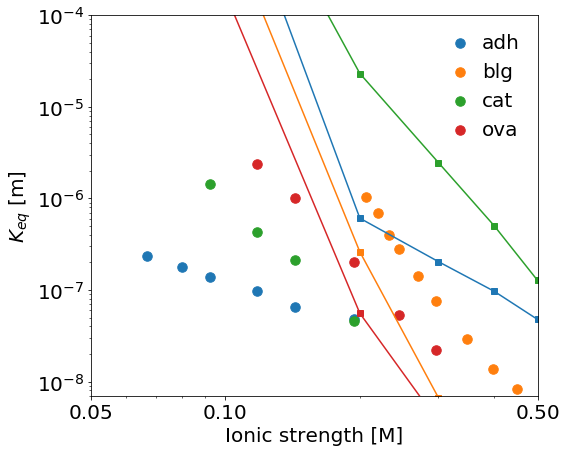

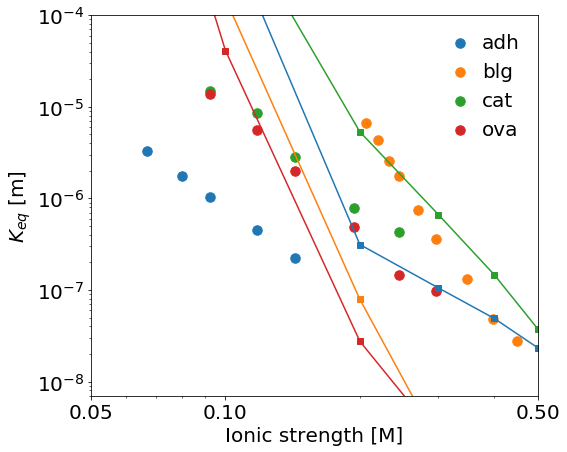

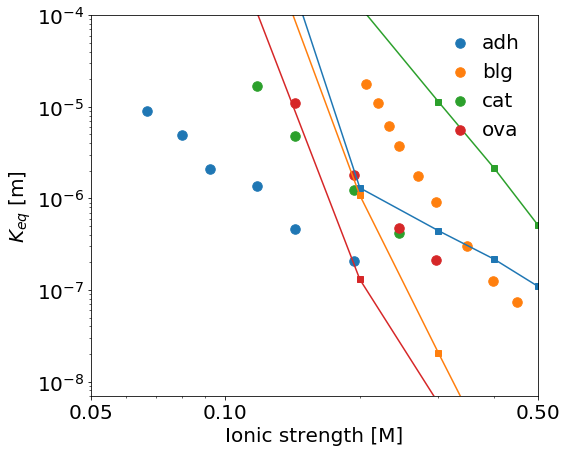

In [5]:
resin_list = ['caq', 'phq', 'pxq']
z0 = 3.0e-10 

res = {}
species_pH = {}
for protein in protein_folders:
    species_pH[protein[:protein.rfind('_')]] = 1

for resin in resin_list:
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 7, forward=True)
    font = {'weight' : 'normal',
            'size'   : 20}
    plt.rc('font', **font)
    ax.set_xlabel('Ionic strength [M]')
    ax.set_ylabel(r'$K_{eq}$ [m]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(7e-9, 1e-4)
    ax.set_xlim(0.05, 0.5)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.set_xticks([0.05, 0.1, 0.5])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    
    for protein in protein_folders:
        if protein[:3] == 'lys':
            pass
        else:
            ion_str = get_ion_str_from_protein_name(protein)
            integrand_df_file = resin + '_' + protein + '_apbs_nonlinear.csv'
            Keq = get_model_Keq_v2([ion_str], integrand_df_file, z0, integrand_dir)[0]
            res[protein] = Keq

    for key in species_pH:
        if key[:3] == 'lys':
            pass
        else:
            
            ion_str = []
            Keq = []
            for rkey in res:
                if rkey[:rkey.rfind('_')] == key:
                    ion_str.append(get_ion_str_from_protein_name(rkey))
                    Keq.append(res[rkey])
            order = np.argsort(ion_str)
            xs = np.array(ion_str)[order]
            ys = np.array(Keq)[order]
            ax.plot(xs, ys, 's-')

            df_exp = get_exp_data(key, resin)
            label = key[:3]
            plot_exp_data_v2(ax, df_exp, label)

    fig.savefig('protein_structure/results/images/zoomed_' + resin + '_' +\
                str(int(round(z0*1.0e12))) + '_pm_z0.png', 
                bbox_inches='tight', dpi = 300)

# Extract charge states from .pqr files

Note poor naming convention below - df_all_c refers to charges extracted from the .pqr file (originally referred to nonzero charges; may include partial charges as of 8/18)

In [3]:
dir_apbs = 'protein_structure/results/apbs_data/'
dir_link = 'protein_structure/results/node_links/'
dir_tabi = 'protein_structure/results/tabi/'
integrand_dir  = 'protein_structure/results/integrand_results/'
energy_dir     = 'protein_structure/results/energy_results/'

protein_folders = os.listdir(dir_apbs)
protein_folders.sort()
protein_folders.remove('multivalue')


In [4]:
def get_fort2_df(protein):
    """Retrieve data in fort2 file - input the name of the protein-IS combo"""
    
    read_dir   = 'ns_bim_spherical/ns_bim_programs/'
    fort2_file = read_dir + protein[:-4] + '/fort.2'
    fort2_df    = pd.read_fwf(fort2_file, skiprows=1, names=['x_A', 'y_A', 'z_A', 'q', 
                              'residue', 'res_num', 'chain', 'unk'], infer_nrows=1000)
    return fort2_df

def get_pqr_df(protein):
    """Retrieve cleaned pqr data"""
    
    file = dir_apbs + protein + '/cleaned_pqr_data.txt'
    df = pd.read_fwf(file, names=['preface', 'atom_n', 'name', 'residue', 'res_num', 
                                  'x', 'y', 'z', 'q', 'radius'], infer_nrows=100000)
    return df

In [5]:
protein_masses_Da           = [149540, 36750, 233120, 14390, 14390, 14390, 43000]
protein_spec_vol_cm3_per_g  = [0.769, 0.75, 0.73, 0.702, 0.702, 0.702, 0.75]

protein_eq_vol_radii_nm = []
for ind, m in enumerate(protein_masses_Da):
    v = protein_spec_vol_cm3_per_g[ind]
    protein_eq_vol_radii_nm.append((0.75/np.pi*m*v/constants().Na)**(1/3)*1.0e7)
    
q_radii = [i - 0.15 for i in protein_eq_vol_radii_nm]

## Clean .pqr data - only needed to run once

In [35]:
sub_string = '.pqr'

for protein in protein_folders:
    # Read files in the current folder
    read_dir = dir_apbs + protein + '/'
    data_files = os.listdir(read_dir)
    
    # Identify pqr file
    pqr_list = [file for file in data_files if sub_string in file]
    try:
        pqr_file = read_dir + pqr_list[0]
        
        # Read .pqr file
        file = open(pqr_file, 'r')
        file_content = file.read().split('\n')

        # Extract atom data
        extract_info = []
        for i, content in enumerate(file_content):
            if content[:4] == 'ATOM':
                extract_info.append(content)

        # Save atom data to text file in the current folder
        with open(read_dir + 'cleaned_pqr_data.txt', 'w') as filehandle:
            filehandle.writelines("%s\n" % line for line in extract_info)
        
    except IndexError:
        print(f'Please note, {protein} does not have a .pqr file.')   

Please note, adh_pH_7_50 does not have a .pqr file.


## Read cleaned_pqr_data.txt and extract relevant charge states

In [42]:
def get_centroid(df_pqr):
    """Compute centroid of the atom data contained in df_pqr"""
    x_cent = 0
    y_cent = 0
    z_cent = 0

    for i_pqr, pqr_content in df_pqr.iterrows():
        x_cent += pqr_content['x']
        y_cent += pqr_content['y']
        z_cent += pqr_content['z']

    x_cent /= len(df_pqr)
    y_cent /= len(df_pqr)
    z_cent /= len(df_pqr)

    return (x_cent, y_cent, z_cent)

##################################################################################
# For discrete charges

def zero_vals():
    return (0, 0, 0, 0, 0)

def add_charged_entry(current_res_num, x_q, y_q, z_q, cnt, q_total, x_cent, y_cent,
                      z_cent, charged_atoms, current_res):
    if abs(q_total) > 1.0e-13:
        try:
            _ = int(current_res_num)
            x = x_q/cnt/abs(q_total) - x_cent
            y = y_q/cnt/abs(q_total) - y_cent
            z = z_q/cnt/abs(q_total) - z_cent
            charged_atoms.append([current_res, current_res_num, x, y, z, q_total])
        except ValueError:
            pass
    return

def get_charge_data(df_pqr, center):
    """Extract the charged amino acids, and compute their centered locations"""
    (x_cent, y_cent, z_cent) = center
    
    charged_atoms = []
    current_res = 'x'
    current_res_num = 'x'
    (q_total, cnt, x_q, y_q, z_q) = zero_vals()

    for i_pqr, pqr_content in df_pqr.iterrows():
        if pqr_content['res_num'] != current_res_num:
            add_charged_entry(current_res_num, x_q, y_q, z_q, cnt, q_total, x_cent,
                              y_cent, z_cent, charged_atoms, current_res)
            
            (q_total, cnt, x_q, y_q, z_q) = zero_vals()
            current_res = pqr_content['residue']
            current_res_num = pqr_content['res_num']
        else:
            pass
        
        q_total += pqr_content['q']
        
        if pqr_content['name'] == 'N' or pqr_content['name'] == 'C'\
        or pqr_content['name'] == 'O' or pqr_content['name'] == 'H':
            pass
        else:
            cnt += 1
            x_q += pqr_content['x']
            y_q += pqr_content['y']
            z_q += pqr_content['z']
    
    add_charged_entry(current_res_num, x_q, y_q, z_q, cnt, q_total, x_cent,
                              y_cent, z_cent, charged_atoms, current_res)
    
    df_all_c = pd.DataFrame(charged_atoms, columns=['residue', 'res_num', 'x', 'y', 
                                                    'z', 'q'])
    return df_all_c

###################################################################################
# For partial charges

def get_charge_data_partial(df_pqr, center):
    """Extract all partial charges, and compute their centered locations.
       (I should have done this originally.)"""
    (x_cent, y_cent, z_cent) = center
    charged_atoms = []
    for i, cont in df_pqr.iterrows():
        if abs(cont['q']) > 1.0e-5:
            try:
                _ = int(cont['res_num'])
                x = cont['x'] - x_cent
                y = cont['y'] - y_cent
                z = cont['z'] - z_cent
                charged_atoms.append([cont['residue'], cont['res_num'], x, y, z, 
                                      cont['q']])
            except ValueError:
                pass   
    df_all_c = pd.DataFrame(charged_atoms, columns=['residue', 'res_num', 'x', 'y', 
                                                    'z', 'q'])
    return df_all_c

###################################################################################

def get_q_radii(df_all_c):
    x = df_all_c['x']
    y = df_all_c['y']
    z = df_all_c['z']
    
    df_all_c['r_original'] = np.sqrt(x**2 + y**2 + z**2)
    return

def scale_radii(df_all_c, q_radius):
    df_all_c['x'] *= q_radius/df_all_c['r_original']
    df_all_c['y'] *= q_radius/df_all_c['r_original']
    df_all_c['z'] *= q_radius/df_all_c['r_original']
    return

def concat_ions_df(df_all_c, ions):
    df_ions = pd.DataFrame(ions, columns=['residue', 'res_num', 'x', 'y', 'z', 'q'])
    df_all_c = pd.concat([df_all_c, df_ions], ignore_index=True)
    return df_all_c

def manual_add_coord_ions(protein, df_all_c):
    name = protein[:protein.rfind('_')]
    if name == 'adh_pH_7':
        ions = [['Zn',9999,2.167060861959575,-1.6889361918099615,-2.040509175810135,2.0],
        ['Zn',9999,3.153456837058953,0.5313843933426834,-1.2188833165343769,2.0],
        ['Zn',9999,191580300774998,1.6255803659911845,-2.065623439779576,2.0],
        ['Zn',9999,-3.1443421241332925,-0.72985208379896,-1.136998011512385,2.0],
        ['Zn',9999,2.166661946653273,1.6881391101238254,2.041592096821218,2.0],
        ['Zn',9999,3.152817636750948,-0.5318432266846276,1.220335883119774,2.0],
        ['Zn',9999,-2.1909063182315696,-1.6255408422581799,2.066369379102252,2.0],
        ['Zn',9999,-3.1439290039437346,0.7291828223709377,1.138568735618706,2.0]]
        df_all_c = concat_ions_df(df_all_c, ions)
        
    elif name == 'cat_pH_7':
        ions = [['Fe',9999,1.9579081494910453,2.559347052853076,-2.2337944337821125,2.0],
        ['Fe',9999,1.017999195177162,2.1847066274765643,3.092609548854454,2.0],
        ['Fe',9999,-1.0052927387998958,-3.1174021504443035,2.15515418773427,2.0],
        ['Fe',9999,-1.9550074136607394,-1.5957087538528196,-3.000859679591192,2.0]]
        df_all_c = concat_ions_df(df_all_c, ions)
        
    else:
        pass
    return df_all_c

def driver_fun_extract_charges(protein, q_radius, get_charge_fun):
    df_pqr   = get_pqr_df(protein)
    center   = get_centroid(df_pqr)
    df_all_c = get_charge_fun(df_pqr, center)
    df_all_c = manual_add_coord_ions(protein, df_all_c)
    get_q_radii(df_all_c)
    scale_radii(df_all_c, q_radius)
    df_all_c.drop(columns=['r_original'], inplace=True)
    return df_all_c

In [316]:
# folder_inds = [0, 6, 12, 18, 19, 20, 21]
folder_inds = [0]


# Get discrete charges
for i, folder_ind in enumerate(folder_inds):
    protein  = protein_folders[folder_ind]
    q_radius = q_radii[i]
    df_all_c = driver_fun_extract_charges(protein, q_radius, get_charge_data)
    file_name = 'ns_bim_spherical/ns_bim_programs/' + protein[:-4] +\
                '/pqr_charges.csv'
    df_all_c.to_csv(file_name, index=False)

In [312]:
folder_inds = [0, 6, 12, 18, 19, 20, 21]

# Get partial charges
for i, folder_ind in enumerate(folder_inds):
    protein  = protein_folders[folder_ind]
    q_radius = q_radii[i]
    df_all_c = driver_fun_extract_charges(protein, q_radius, get_charge_data_partial)
    file_name = 'ns_bim_spherical/ns_bim_programs/' + protein[:-4] +\
                '/pqr_partial_charges.csv'
    df_all_c.to_csv(file_name, index=False)

## For monomer spheres - read cleaned_pqr_data.txt and extract relevant charge states 

In [171]:
class monomer:
    def __init__(self):
        return

def get_distance_pts(p1, p2):
    (x1, y1, z1) = p1
    (x2, y2, z2) = p2
    xd = x1 - x2
    yd = y1 - y2
    zd = z1 - z2
    return np.sqrt(xd**2 + yd**2 + zd**2)

def get_chain_inds(df_pqr):
    res_num = 0
    inds = []
    for i, cont in df_pqr.iterrows():
        if cont['res_num'] < res_num:
            inds.append(i)
        res_num = cont['res_num']    
    return inds

def split_df_pqr(df_pqr, inds_df):
    mono_dict = {}
    for i in range(len(inds_df) + 1):
        mono_dict[i] = monomer()
        
        if i == 0:
            mono_dict[i].df_pqr = df_pqr[:inds_df[0]].copy()
        elif i == len(inds_df):
            mono_dict[i].df_pqr = df_pqr[inds_df[-1]:].copy()
        else:
            mono_dict[i].df_pqr = df_pqr[inds_df[i - 1]:inds_df[i]].copy()  
    return mono_dict
    
def get_mono_charges(mono_dict, get_charge_fun):
    for i in mono_dict:
        mono_dict[i].center = get_centroid(mono_dict[i].df_pqr)
        mono_dict[i].df_q   = get_charge_fun(mono_dict[i].df_pqr, mono_dict[i].center)
    return

def get_centers(mono_dict):
    cents = []
    for i in mono_dict:
        cents.append(mono_dict[i].center)
    return cents
    
def get_max_radius(mono_dict):
    gap_A = 0.01
    cents = get_centers(mono_dict)   
    distances = []
    for i, i_cent in enumerate(cents):
        if i_cent == cents[-1]:
            pass
        else:
            for j in range(i+1, len(cents)):
                distances.append(get_distance_pts(i_cent, cents[j]))
    max_radius = min(distances)/2 - gap_A
    return max_radius

def scale_q_radii(mono_dict, depth_A):
    radius = get_max_radius(mono_dict) - depth_A    
    for i in mono_dict:
        get_q_radii(mono_dict[i].df_q)
        scale_radii(mono_dict[i].df_q, radius)
    return
            
def shift_monomers(mono_dict):
    for i in mono_dict:
        mono_dict[i].df_q['x'] += mono_dict[i].center[0]
        mono_dict[i].df_q['y'] += mono_dict[i].center[1]
        mono_dict[i].df_q['z'] += mono_dict[i].center[2]
    return

def get_ions(protein):
    if protein[:3] == 'adh':
        ion_q = 2
        coordinates = [[89.392, -13.891, 47.311], [93.826,  3.753, 55.492], 
                       [52.531,  14.121, 46.155], [49.633, -5.089, 56.165], 
                       [89.392,  13.891, 80.893], [93.826, -3.753, 72.712],
                       [52.531, -14.121, 82.049], [49.633,  5.089, 72.039]]
    elif protein[:3] == 'cat':
        ion_q = 2
        coordinates = [[33.463, 42.462, 29.012], [27.805, 39.976, 59.926],
                       [16.090,  9.237, 54.712], [10.482, 18.053, 24.539]]
    else:
        ion_q       = None
        coordinates = None
    return (ion_q, coordinates)


def add_ions(protein, mono_dict, radius=-1):
    (ion_q, coordinates) = get_ions(protein)
    cents = get_centers(mono_dict)
    
    if radius == -1:
        radius = get_max_radius(mono_dict)
    
    new_q_coord = []
    if coordinates is not None:
        for coord in coordinates:
            # Pair with closest monomer, get original radius
            dist = []
            for center in cents:
                dist.append(get_distance_pts(coord, center))
            for i, d in enumerate(dist):
                if d == min(dist):
                    r_original = d
                    center_ind = i
            
            # Set location
            x_orig_vec = coord[0] - cents[center_ind][0]
            y_orig_vec = coord[1] - cents[center_ind][1]
            z_orig_vec = coord[2] - cents[center_ind][2]
            
            x_unit_vec = x_orig_vec/r_original
            y_unit_vec = y_orig_vec/r_original
            z_unit_vec = z_orig_vec/r_original
            
            x_new = cents[center_ind][0] + radius*x_unit_vec
            y_new = cents[center_ind][1] + radius*y_unit_vec
            z_new = cents[center_ind][2] + radius*z_unit_vec
            
            # Add to the appropriate monomer df
            for i in mono_dict:
                if mono_dict[i].center == cents[center_ind]:
                    next_res = 1 +\
                    mono_dict[i].df_q.at[len(mono_dict[i].df_q)-1, 'res_num']
                    
                    df_temp = pd.DataFrame([['ion', next_res, x_new, y_new, z_new,
                                            ion_q, r_original]], 
                                           columns=mono_dict[i].df_q.columns)
                    mono_dict[i].df_q = mono_dict[i].df_q.append(df_temp,
                                                                 ignore_index=True)
    return
            
def scale_coords_A_to_nm(mono_dict):
    for i in mono_dict:
        mono_dict[i].df_q['x'] *= 0.1
        mono_dict[i].df_q['y'] *= 0.1
        mono_dict[i].df_q['z'] *= 0.1
    return

def prep_for_ns_bim(mono_dict):
    for i in mono_dict:
        mono_dict[i].df_q.drop(columns=['residue', 'res_num', 'r_original'], 
                               inplace=True)
        for j, cont in mono_dict[i].df_q.iterrows():
            mono_dict[i].df_q.at[j, 'number'] = j + 1
        mono_dict[i].df_q = mono_dict[i].df_q.astype({'number': 'int32'}, copy=False)
        mono_dict[i].df_q = mono_dict[i].df_q[['number', 'x', 'y', 'z', 'q']]
    return




def driver_fun_mono(protein, get_charge_fun=get_charge_data_partial):
    df_pqr    = get_pqr_df(protein)
    inds_df   = get_chain_inds(df_pqr)
    mono_dict = split_df_pqr(df_pqr, inds_df)
    get_mono_charges(mono_dict, get_charge_fun)
    scale_q_radii(mono_dict, depth_A=1.5)
    shift_monomers(mono_dict)
    add_ions(protein, mono_dict)
    scale_coords_A_to_nm(mono_dict)
    prep_for_ns_bim(mono_dict)
    return mono_dict

###############################################################################
# Validation

def plot_sphere(ax, center, radius, alpha=0.1):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
    ax.plot_surface(x, y, z, alpha=alpha)



In [489]:
from modules_ns_bim_spherical.v2_ns_bim_helper_plus import my_mk_dir
dest_dir   = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/'
new_folder = '/pqr_partial_charges/'

folder_inds = [0, 6, 12]
# folder_inds = [12]

for i in folder_inds:
    protein   = protein_folders[i]
    mono_dict = driver_fun_mono(protein)
    
    new_dir   = dest_dir + protein[:-4] + new_folder
    my_mk_dir(new_dir)
    for i in mono_dict:
        mono_dict[i].df_q.to_csv(new_dir + 'monomer_' + str(i) + '.csv', index=False)
    

Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/adh_pH_7/pqr_partial_charges/ failed
Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/blg_pH_7/pqr_partial_charges/ failed
Creation of the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/cat_pH_7/pqr_partial_charges/ failed


In [493]:
# Print needed info for NS-BIM

folder_inds = [0, 6, 12]

for i in folder_inds:
    protein   = protein_folders[i]
    mono_dict = driver_fun_mono(protein)
    radius    = get_max_radius(mono_dict)/10
    print(f"{protein}, radius: {radius}")
    
    for i in mono_dict:
        center = [i/10 for i in mono_dict[i].center]
        n_q = len(mono_dict[i].df_q)
        print(f"{i}, center: {center}, n_q: {n_q}")
    print('\n')
    

adh_pH_7_100, radius: 2.043110489167666
0, center: [8.709394351708072, -1.5296158190993778, 4.928530512422363], n_q: 2358
1, center: [8.709410554908805, 1.5294163950329822, 7.891993810632515], n_q: 2359
2, center: [5.608398272850765, 1.3707219871919287, 4.893960353192316], n_q: 2359
3, center: [5.608677436893194, -1.3710306601941757, 7.926507650485439], n_q: 2357


blg_pH_7_100, radius: 1.5917482696520016
0, center: [-1.2040045052292834, 1.4313766693483518, -0.8429396218825433], n_q: 1076
1, center: [-0.48055897023330596, 0.16723769106999192, 1.9900742156074025], n_q: 1076


cat_pH_7_100, radius: 1.7103369981108087
0, center: [3.6748934901462307, 3.8683134901462273, 2.549178448823908], n_q: 3950
1, center: [2.278153426573429, 4.112578308963764, 6.304106293706303], n_q: 3950
2, center: [2.1574011064479253, 0.741375073127305, 5.709500457840504], n_q: 3947
3, center: [0.6726974958688189, 2.2442569086055713, 2.296281797381461], n_q: 3952




### Modification to ADH charge states near Zn
Removal of Cys and Zn

In [23]:
from modules_ns_bim_spherical.v2_ns_bim_helper_plus import my_mk_dir
dest_dir   = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/'
new_folder = '/pqr_partial_charges_mod_coord/'

folder_inds = [0]

for i in folder_inds:
    protein   = protein_folders[i]
    
    df_pqr    = get_pqr_df(protein)
    inds = []
    for j, cont in df_pqr.iterrows():
        if cont['residue'] == 'CYS' and \
        (cont['res_num'] == 43 or cont['res_num'] == 100):
            inds.append(j)
    df_pqr.drop(index=inds, inplace=True)
    df_pqr.reset_index(inplace=True)
    
    inds_df   = get_chain_inds(df_pqr)
    mono_dict = split_df_pqr(df_pqr, inds_df)
    get_mono_charges(mono_dict, get_charge_data_partial)
    scale_q_radii(mono_dict, depth_A=1.5)
    shift_monomers(mono_dict)
#     add_ions(protein, mono_dict, radius)
    scale_coords_A_to_nm(mono_dict)
    prep_for_ns_bim(mono_dict)
    
    new_dir   = dest_dir + protein[:-4] + new_folder
    my_mk_dir(new_dir)
    for i in mono_dict:
        mono_dict[i].df_q.to_csv(new_dir + 'monomer_' + str(i) + '.csv', index=False)
    

Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/adh_pH_7/pqr_partial_charges_mod_coord/


In [24]:
# Print needed info for NS-BIM
radius    = get_max_radius(mono_dict)/10
print(f"{protein}, radius: {radius}")

for i in mono_dict:
    center = [i/10 for i in mono_dict[i].center]
    n_q = len(mono_dict[i].df_q)
    print(f"{i}, center: {center}, n_q: {n_q}")
    

adh_pH_7_100, radius: 2.0464486240696425
0, center: [8.707670615744346, -1.5335016757599362, 4.927835463756822], n_q: 2344
1, center: [8.707601013052791, 1.5337017923241745, 7.892797818040127], n_q: 2345
2, center: [5.610246784879189, 1.3748913678877648, 4.893233943881528], n_q: 2345
3, center: [5.610528329108979, -1.375203723922793, 7.927234665626831], n_q: 2343


## Discrete charges for monomer spheres

In [14]:
from modules_ns_bim_spherical.v2_ns_bim_helper_plus import my_mk_dir
dest_dir   = 'ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/'
new_folder = '/pqr_discrete_charges/'

folder_inds = [0, 6, 12]

for i in folder_inds:
    protein   = protein_folders[i]
    mono_dict = driver_fun_mono(protein, get_charge_data)
    
    new_dir   = dest_dir + protein[:-4] + new_folder
    my_mk_dir(new_dir)
    for i in mono_dict:
        mono_dict[i].df_q.to_csv(new_dir + 'monomer_' + str(i) + '.csv', index=False)
    

Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/adh_pH_7/pqr_discrete_charges/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/blg_pH_7/pqr_discrete_charges/
Successfully created the directory ns_bim_monomer_spheres/ns_bim_programs_pqr_partial_charges/cat_pH_7/pqr_discrete_charges/


In [16]:
folder_inds = [0, 6, 12]

for i in folder_inds:
    protein   = protein_folders[i]
    mono_dict = driver_fun_mono(protein, get_charge_data)
    radius    = get_max_radius(mono_dict)/10
    print(f"{protein}, radius: {radius}")
    
    for i in mono_dict:
        center = [i/10 for i in mono_dict[i].center]
        n_q = len(mono_dict[i].df_q)
        print(f"{i}, center: {center}, n_q: {n_q}")
    print('\n')

adh_pH_7_100, radius: 2.043110489167666
0, center: [8.709394351708072, -1.5296158190993778, 4.928530512422363], n_q: 73
1, center: [8.709410554908805, 1.5294163950329822, 7.891993810632515], n_q: 69
2, center: [5.608398272850765, 1.3707219871919287, 4.893960353192316], n_q: 72
3, center: [5.608677436893194, -1.3710306601941757, 7.926507650485439], n_q: 73


blg_pH_7_100, radius: 1.5917482696520016
0, center: [-1.2040045052292834, 1.4313766693483518, -0.8429396218825433], n_q: 46
1, center: [-0.48055897023330596, 0.16723769106999192, 1.9900742156074025], n_q: 46


cat_pH_7_100, radius: 1.7103369981108087
0, center: [3.6748934901462307, 3.8683134901462273, 2.549178448823908], n_q: 114
1, center: [2.278153426573429, 4.112578308963764, 6.304106293706303], n_q: 114
2, center: [2.1574011064479253, 0.741375073127305, 5.709500457840504], n_q: 114
3, center: [0.6726974958688189, 2.2442569086055713, 2.296281797381461], n_q: 112




### Validation

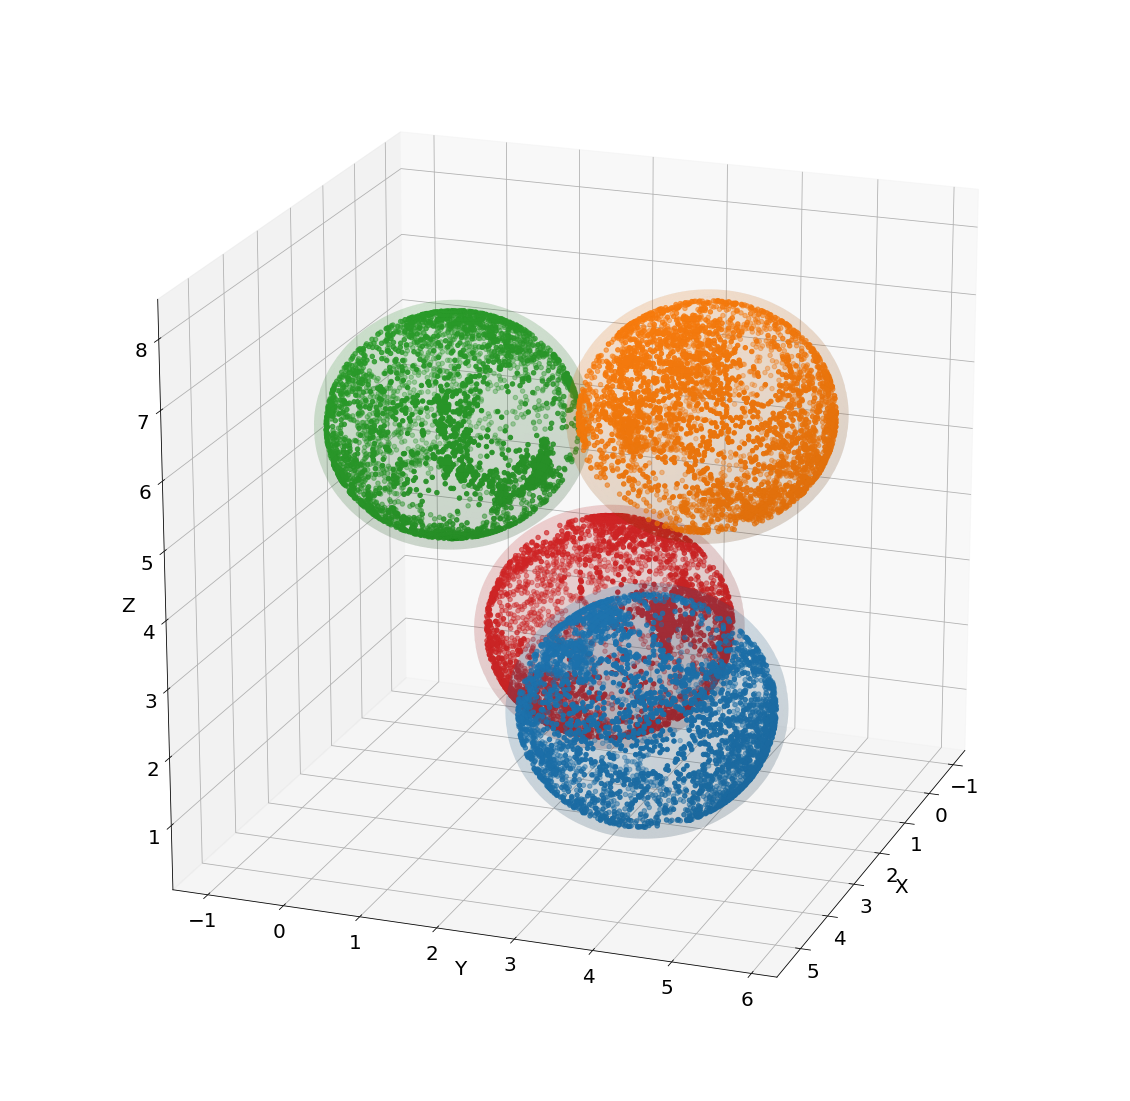

In [465]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

label_size = 20
ax.set_xlabel('X', size=label_size)
ax.set_ylabel('Y', size=label_size)
ax.set_zlabel('Z', size=label_size)
fig.set_size_inches(20, 20, forward=True)
ax.view_init(20, 20)

radius = get_max_radius(mono_dict)/10
for i in mono_dict:
    ax.scatter(mono_dict[i].df_q['x'], mono_dict[i].df_q['y'], mono_dict[i].df_q['z'])
    center = [i/10 for i in mono_dict[i].center]
    plot_sphere(ax, center, radius)
    


In [481]:
radius = get_max_radius(mono_dict)/10

for i in mono_dict:
    center = [i/10 for i in mono_dict[i].center]
    mono_dict[i].df_q['radius'] = get_distance_pts([mono_dict[i].df_q['x'], 
                                                mono_dict[i].df_q['y'],
                                                mono_dict[i].df_q['z']], 
                                                center)
    for ind, cont in mono_dict[i].df_q.iterrows():
        if cont['radius'] > radius:
            print(ind, cont['radius']-radius)

## What are the differences between the charge state contributions between PDB2PQR and ProCharger?
With respect to ProCharger as the baseline

In [189]:
def clean_termini(residues):
    for i, res in enumerate(residues):
        if res[:3] == 'N+_' or res[:3] == 'C-_':
            residues[i] = res[3:]  
    return residues

def extract_unique(my_list):
    my_set = set(my_list)
    return list(my_set)

def remove_ions(residues):
    try:
        residues.remove('Zn')
    except:
        pass
    try:
        residues.remove('Fe')
    except:
        pass
    return residues

def initialize_res_dict(residues):
    contribs = {}
    for res in residues:
        contribs[res] = 0.0
    return contribs
    
def get_contributions(df):
    df['residue'] = clean_termini(df['residue'])
    residues = extract_unique(df['residue'])
    residues = remove_ions(residues)
    contribs = initialize_res_dict(residues)
    
    for i, cont in df.iterrows():
        if cont['residue'] in residues:
            contribs[cont['residue']] += cont['q']
    return contribs
 
def get_contrib_res(dict_1, dict_2):
    res_1 = list(dict_1.keys())
    res_2 = list(dict_2.keys())
    for i in res_2:
        res_1.append(i)
    return extract_unique(res_1)

def zero_fill_vals(all_keys, my_dict):
    for key in all_keys:
        if key not in my_dict.keys():
            my_dict[key] = 0.0
    return my_dict

def get_dict_diffs(dict_1, dict_2):
    residues = get_contrib_res(dict_1, dict_2)
    dict_1 = zero_fill_vals(residues, dict_1)
    dict_2 = zero_fill_vals(residues, dict_2)
    
    dict_diff = initialize_res_dict(residues)
    for res in residues:
        dict_diff[res] = dict_1[res] - dict_2[res]
    return dict_diff

def get_unique_nested_keys(nested_dict):
    keys = []
    for key in nested_dict:
        for k_sub in nested_dict[key]:
            keys.append(k_sub)
    return extract_unique(keys)


In [218]:
folder_inds = [0, 6, 12, 18, 19, 20, 21]
nested_dict_diff = {}

for i, folder_ind in enumerate(folder_inds):
    protein   = protein_folders[folder_ind]
    file_name = 'ns_bim_spherical/ns_bim_programs/' + protein[:-4] + '/pqr_charges.csv'
    df_all_c  = pd.read_csv(file_name)
    contribs_pqr = get_contributions(df_all_c)

    df_fort = get_fort2_df(protein)
    contribs_fort = get_contributions(df_fort)
    
    contrib_diff = get_dict_diffs(contribs_pqr, contribs_fort)
    nested_dict_diff[protein[:-4]] = contrib_diff
    
all_keys = get_unique_nested_keys(nested_dict_diff)
for key in nested_dict_diff:
    nested_dict_diff[key] = zero_fill_vals(all_keys, nested_dict_diff[key])
    
index = [protein_folders[i][:-4] for i in folder_inds]
master_df = pd.DataFrame(index=index, columns=all_keys)

for prot, cont in master_df.iterrows():
    for key in all_keys:
        master_df.at[prot, key] = nested_dict_diff[prot][key]
master_df.drop(labels=['FE', 'ZN'], axis='columns', inplace=True)

for prot, cont in master_df.iterrows():
    master_df.at[prot, 'Total'] = sum(cont)

/home/chase/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [213]:
master_df

,TYR,PRO,HIS,LYS,LEU,CYS,ASP,ARG,GLU,SER,GLN,ASN,Total
adh_pH_7,0.0504,0,-3.636,-45.9712,0,-4,33.9552,-16,39.856,-1.972,0,0,2.2824
blg_pH_7,0.0072,0,-0.1818,0.009,0,-2,-0.014,8.88178e-16,-0.0576,0,0.0148,0,-2.2224
cat_pH_7,0.072,0,-7.6356,-0.97,0,0,17.8936,-4,-1.1728,0,0,0.3636,4.5508
lys_pH_5,0,0,0.0909,-0.9999,-0.0023,0,-0.4732,0,0.698,0,0,0,-0.6865
lys_pH_7,0.0027,0,-0.0909,-0.9868,0,0,-0.0049,0,-0.0036,0,0,0,-1.0835
lys_pH_9,-0.7648,0,-0.001,-1.2703,0,0,0,0.0033,0,0,0,0,-2.0328
ova_pH_7,0.009,-0.0001,0.3637,1.0054,0,0,-0.0091,1,-7.0378,0,0,0,-4.6689


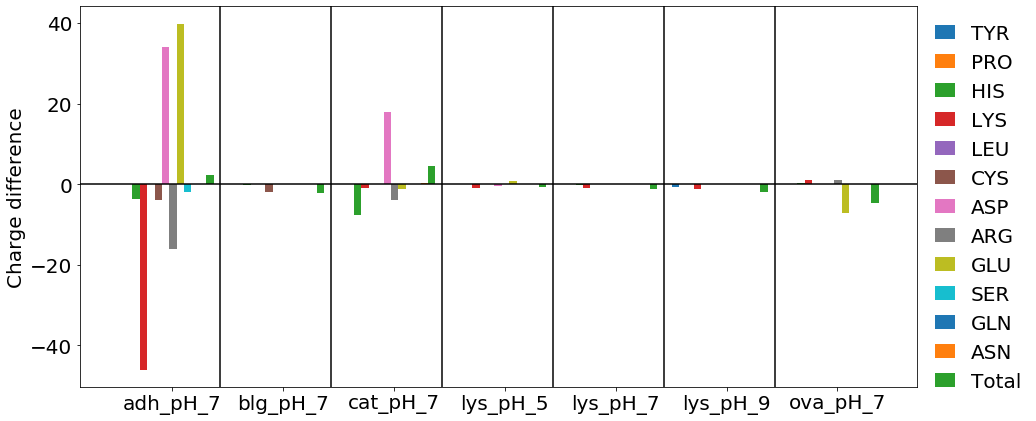

In [210]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)

ax.set_ylabel('Charge difference')
x = np.arange(len(index))
ax.set_xticks(x)
ax.set_xticklabels(index)

cols = master_df.columns
width = 1/15
x_offset = {}
for i, col in enumerate(cols):
    x_offset[col] = width*i

for col, cont in master_df.iteritems():
    xs = x - 6/13 + x_offset[col]
    rect = ax.bar(xs, cont, width, label=col)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, handlelength=1, 
          frameon=False)

ax.axhline(color='black')
(ymin, ymax) = ax.get_ylim()
ax.set_ylim(ymin, ymax)
x_vlines = list(x + 0.5 - width)
x_vlines.pop()
ax.vlines(x_vlines, ymin, ymax, color='black')

fig.savefig('charger_differences.png', bbox_inches='tight', dpi=300)

### Zoomed-in view; must re-run the cells above before running the second cell below 

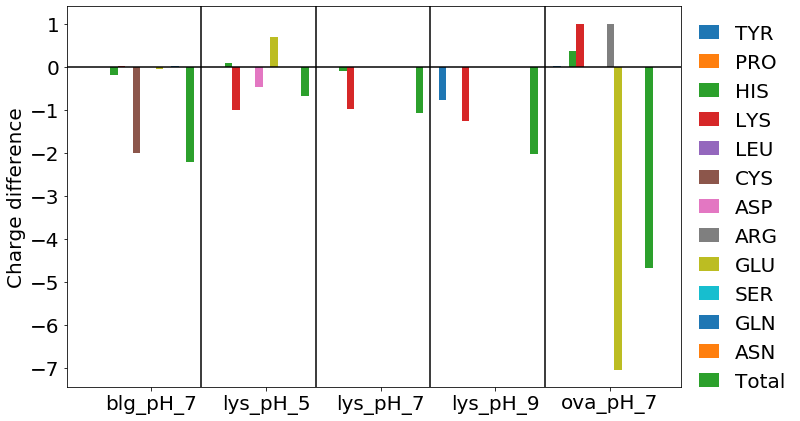

In [215]:
master_df.drop(labels=['adh_pH_7', 'cat_pH_7'], axis=0, inplace=True)
index = master_df.index

fig, ax = plt.subplots()
fig.set_size_inches(11, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)

ax.set_ylabel('Charge difference')
x = np.arange(len(index))
ax.set_xticks(x)
ax.set_xticklabels(index)

cols = master_df.columns
width = 1/15
x_offset = {}
for i, col in enumerate(cols):
    x_offset[col] = width*i

for col, cont in master_df.iteritems():
    xs = x - 6/13 + x_offset[col]
    rect = ax.bar(xs, cont, width, label=col)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, handlelength=1, 
          frameon=False)

ax.axhline(color='black')
(ymin, ymax) = ax.get_ylim()
ax.set_ylim(ymin, ymax)
x_vlines = list(x + 0.5 - width)
x_vlines.pop()
ax.vlines(x_vlines, ymin, ymax, color='black')

fig.savefig('charger_differences_select.png', bbox_inches='tight', dpi=300)

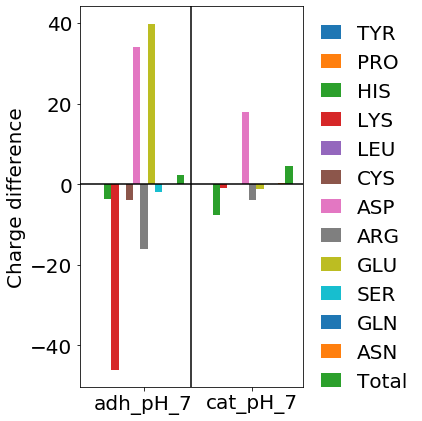

In [219]:
master_df.drop(labels=['blg_pH_7', 'lys_pH_5', 'lys_pH_7', 'lys_pH_9', 'ova_pH_7'], 
               axis=0, inplace=True)
index = master_df.index

fig, ax = plt.subplots()
fig.set_size_inches(4, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)

ax.set_ylabel('Charge difference')
x = np.arange(len(index))
ax.set_xticks(x)
ax.set_xticklabels(index)

cols = master_df.columns
width = 1/15
x_offset = {}
for i, col in enumerate(cols):
    x_offset[col] = width*i

for col, cont in master_df.iteritems():
    xs = x - 6/13 + x_offset[col]
    rect = ax.bar(xs, cont, width, label=col)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, handlelength=1, 
          frameon=False)

ax.axhline(color='black')
(ymin, ymax) = ax.get_ylim()
ax.set_ylim(ymin, ymax)
x_vlines = list(x + 0.5 - width)
x_vlines.pop()
ax.vlines(x_vlines, ymin, ymax, color='black')

fig.savefig('charger_differences_select_2.png', bbox_inches='tight', dpi=300)

Note:  .pqr files are only a function of the protein and pH, not ionic strength. - Only needed to run once.

In [214]:
protein = protein_folders[-1]
df_pqr_1 = get_pqr_df(protein)

protein = protein_folders[-2]
df_pqr_2 = get_pqr_df(protein)

a = (df_pqr_1 == df_pqr_2)
a.all()

preface    True
atom_n     True
name       True
residue    True
res_num    True
x          True
y          True
z          True
q          True
radius     True
dtype: bool

## Compare ADH and CAT

In [50]:
folder   = 'ns_bim_spherical/ns_bim_programs/'
# proteins = ['adh_pH_7', 'cat_pH_7']
proteins = ['adh_pH_7', 'blg_pH_7', 'cat_pH_7', 'ova_pH_7']

df_all_q = pd.DataFrame()
for protein in proteins:
    df_file  = folder + protein + '/pqr_charges.csv'
    df_char  = pd.read_csv(df_file, header=0)

    def get_unique_aa(df):
        charges = {}
        for ind, cont in df.iterrows():
            charges[cont['residue']] = 0
        return charges

    charges = get_unique_aa(df_char)
    for ind, cont in df_char.iterrows():
        charges[cont['residue']] += cont['q']

    for key in charges:
        df_all_q.at[key, protein] = charges[key]
    
df_all_q.fillna(0, inplace=True)

totals = {}
for ind, cont in df_all_q.iteritems():
    totals[ind] = sum(cont)
for protein in totals:
    df_all_q.at['Total', protein] = totals[protein]
    
df_all_q

,adh_pH_7,blg_pH_7,cat_pH_7,ova_pH_7
SER,4.0,0.0,0.000000e+00,0.0
GLU,-79.0,-32.0,-9.700000e+01,-28.0
LYS,92.0,30.0,9.900000e+01,19.0
ASP,-62.0,-20.0,-1.340000e+02,-13.0
CYS,-8.0,-2.0,0.000000e+00,0.0
HIS,2.0,0.0,0.000000e+00,1.0
ARG,32.0,6.0,1.200000e+02,15.0
Zn,16.0,0.0,0.000000e+00,0.0
GLN,0.0,2.0,0.000000e+00,0.0
ASN,0.0,0.0,4.000000e+00,0.0


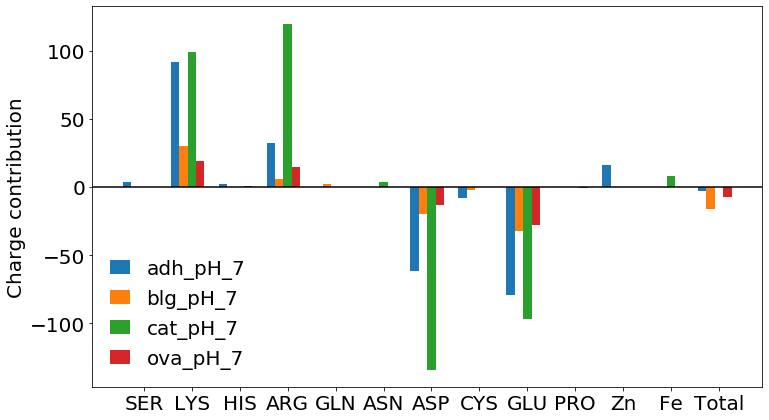

In [59]:
df_all_q = df_all_q.reindex(index=['SER', 'LYS', 'HIS', 'ARG', 'GLN', 'ASN',
                                   'ASP', 'CYS', 'GLU', 'PRO', 'Zn', 'Fe', 'Total'])

fig, ax = plt.subplots()
fig.set_size_inches(12, 7, forward=True)
font = {'weight': 'normal', 'size': 20}
plt.rc('font', **font)

x = np.arange(len(df_all_q.index))

for i, protein in enumerate(proteins):
#     width = 0.35
#     rects1 = ax.bar(x - width/2 + width*i, df_all_q[protein], width, label=protein)
    width = 0.35/2
    rects1 = ax.bar(x - 2*width + width*i, df_all_q[protein], width, label=protein)

ax.set_ylabel('Charge contribution')
ax.set_xticks(x)
ax.set_xticklabels(df_all_q.index)
ax.legend(handlelength=1, frameon=False, loc='lower left')
ax.axhline(color='black')

fig.savefig('ns_bim_spherical/images_general/charge_states/pqr_aex_protein_comparison.png', 
            bbox_inches='tight', dpi=300)

In [52]:
df_all_q.index

Index(['SER', 'GLU', 'LYS', 'ASP', 'CYS', 'HIS', 'ARG', 'Zn', 'GLN', 'ASN',
       'Fe', 'PRO', 'Total'],
      dtype='object')

# Set up mAb D

Using panda's read_fwf

In [49]:
def get_pdb_df(file):
    """Retrieve pdb-formatted data"""
    df = pd.read_fwf(file, names=['atom', 'atom_n', 'name', 'residue', 'res_num', 
                    'x', 'y', 'z', 'j1', 'j2'], infer_nrows=1500)
    return df

pdb_files = ['fab_1.pdb', 'fab_2.pdb', 'fc.pdb']
centroids = {}
for i in pdb_files:
    file = 'ns_bim_monomer_spheres/ns_bim_program_mab_D/' + i
    df   = get_pdb_df(file)
    df.dropna(axis='index', inplace=True)
    centroid = [np.mean(np.array(df['x'])), np.mean(np.array(df['y'])),
                np.mean(np.array(df['z']))]
    centroids[i[:i.rfind('.')]] = centroid
    print(i, centroid)

centroids['fc'] = [10.858,-53.506,-32.908]
print('\n')
for key in centroids.keys():
    print(key)

fab_1.pdb [8.99586830553117, -10.815515071700322, -65.2523289435177]
fab_2.pdb [5.088067310506292, -1.16825577992391, -1.4942405618963996]
fc.pdb [13.889494543365881, -53.51123894313613, -32.916446008041355]


fab_1
fab_2
fc


In [32]:
def get_max_radius_centroids(cents):
    gap_A = 0.01
    distances = []
    for i, i_cent in enumerate(cents):
        if i_cent == cents[-1]:
            pass
        else:
            for j in range(i+1, len(cents)):
                distances.append(get_distance_pts(i_cent, cents[j]))
    max_radius = min(distances)/2 - gap_A
    return max_radius

r_max = get_max_radius_centroids(centroids)
print(r_max)

26.880898738599026


Using ProCharger

In [30]:
cents = [[8.996, -10.816, -65.429], [5.088, -1.168, -1.494], [10.858,-53.506,-32.908]]
r_max = get_max_radius_centroids(cents)
print(r_max)

26.83920196672519


Validation plot

In [37]:
base_dir = 'ns_bim_monomer_spheres/ns_bim_program_mab_D/'
folders  = ['fab_1', 'fab_2', 'fc']
mono_dict = {}

for f in folders:
    file = base_dir + f + '/fort8_for_NSBIM.csv'
    df = pd.read_csv(file, names=['n', 'x', 'y', 'z', 'q'])
    mono_dict[f] = monomer()
    mono_dict[f].df_q = df

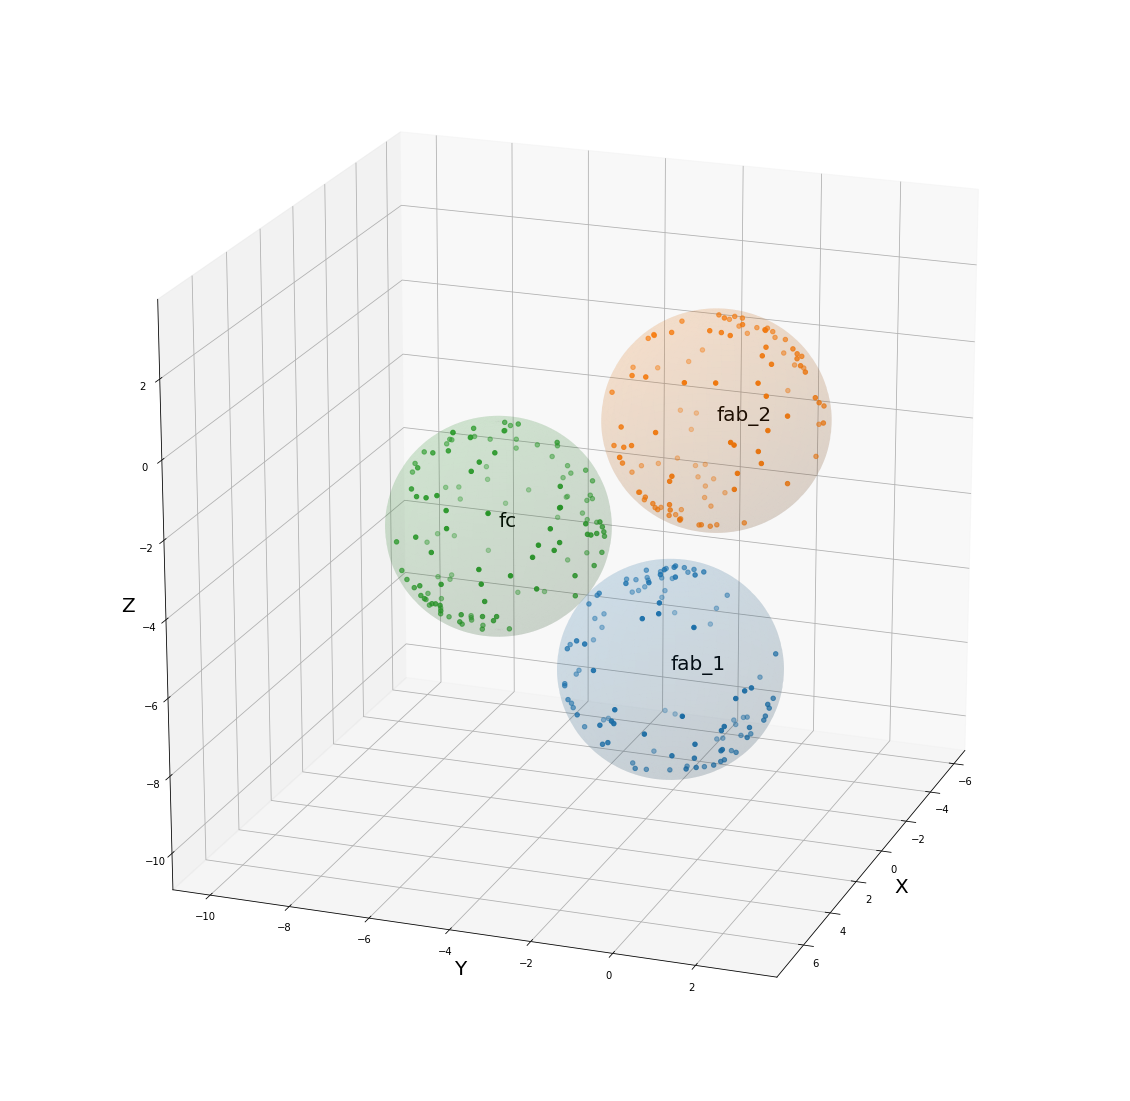

In [78]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

label_size = 20
ax.set_xlabel('X', size=label_size)
ax.set_ylabel('Y', size=label_size)
ax.set_zlabel('Z', size=label_size)
fig.set_size_inches(20, 20, forward=True)
ax.view_init(20, 20)

radius = r_max/10
for i in mono_dict:
    ax.scatter(mono_dict[i].df_q['x'], mono_dict[i].df_q['y'], mono_dict[i].df_q['z'])
    center = [i/10 for i in centroids[i]]
    plot_sphere(ax, center, radius)
    ax.text(center[0], center[1], center[2], i, fontsize=20)

X, Y, Z = np.array([-3, 4]), np.array([-10, 3]), np.array([-10, 3])
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')
    
fig.savefig(base_dir+'charge_placement.png', bbox_inches='tight', dpi=300)

In [85]:
for i in mono_dict:
#     print(i, '\n', mono_dict[i].df_q.tail(), '\n')
    print(i, sum(mono_dict[i].df_q['q']))

fab_1 5.373500000000007
fab_2 5.373500000000007
fc -6.041999999999993


# Set up mAb D 2

In [223]:
def get_pdb_df(file):
    """Retrieve pdb-formatted data"""
    df = pd.read_fwf(file, names=['atom', 'atom_n', 'name', 'residue', 'res_num', 
                    'x', 'y', 'z', 'j1', 'j2'], infer_nrows=500)
    return df

def get_max_radius_centroids(cents):
    gap_A = 0.01
    distances = []
    for i, i_cent in enumerate(cents):
        if i_cent == cents[-1]:
            pass
        else:
            for j in range(i+1, len(cents)):
                distances.append(get_distance_pts(i_cent, cents[j]))
    max_radius = min(distances)/2 - gap_A
    return max_radius

def get_aa_mass(aa):
    mass = {'A':71.09,
            'R':156.19,
            'N':114.11,
            'D':115.09,
            'C':103.15,
            'Q':128.14,
            'E':129.12,
            'G':57.05,
            'H':137.14,
            'I':113.16,
            'L':113.16,
            'K':128.17,
            'M':131.19,
            'F':147.18,
            'P':97.12,
            'S':87.08,
            'T':101.11,
            'W':186.21,
            'Y':163.18,
            'V':99.14}
    try:
        return mass[aa]
    except:
        print('Nonstandard input')
        return
    
def three_letter_aa_to_one(aa3):
    conversion = {'ALA':'A',
                 'GLY':'G',
                 'ILE':'I',
                 'LEU':'L',
                 'PRO':'P',
                 'VAL':'V',
                 'PHE':'F',
                 'TRP':'W',
                 'TYR':'Y',
                 'ASP':'D',
                 'GLU':'E',
                 'ARG':'R',
                 'HIS':'H',
                 'LYS':'K',
                 'SER':'S',
                 'THR':'T',
                 'CYS':'C',
                 'MET':'M',
                 'ASN':'N',
                 'GLN':'Q'}
    try:
        return conversion[aa3]
    except:
        print(f'Nonstandard input:  {aa3}')
        return

def get_aa3_mass(aa3):
    aa = three_letter_aa_to_one(aa3)
    return get_aa_mass(aa)

def get_chain_mass(df_pdb):
    mass = 0
    res_num = 0.0
    for i, cont in df_pdb.iterrows():
        if cont['res_num'] != res_num:
            mass += get_aa3_mass(cont['residue'])
            res_num = cont['res_num']
    return mass

def get_gaps(cents, radii):
    distances = []
    for i, i_cent in enumerate(cents):
        if i_cent == cents[-1]:
            pass
        else:
            for j in range(i+1, len(cents)):
                distances.append(get_distance_pts(i_cent, cents[j]) - radii[i] - radii[j])
                if distances[-1] < 0.0:
                    distances[-1] = 1.0e10
    return distances


def get_gap_sum(cents, radii):
    distances = get_gaps(cents, radii)
    return sum(distances)

def get_radii(scale, masses):
    return [scale*(i**(1.0/3.0)) for i in masses]

def calc_gap_obj_fun(scale, cents, masses):
    radii = get_radii(scale, masses)
    print(scale, get_gap_sum(cents, radii)) # radii, get_gap_sum(cents, radii), '\n'
    return get_gap_sum(cents, radii)

def avoid_overlap(scale, cents, masses): # Unsure why this is ignored...
    radii = get_radii(scale, masses)
    gaps = np.array(get_gaps(cents, radii))
    if np.any(gaps < 0.0):
        return -1.0
    else:
        return 1.0
    
def solve_for_radii_scale(cents, masses):
    fit = scipy.optimize.minimize(calc_gap_obj_fun, x0=0.0, args=(cents, masses))
    return fit




In [158]:
centroids = {}
masses = {}

for f in folders:
    file = 'ns_bim_monomer_spheres/ns_bim_program_mab_D_2/'+f+'/'+f+'.pdb'
    df   = get_pdb_df(file)
    df.dropna(axis='index', inplace=True)    
    centroid = [np.mean(np.array(df['x'])), np.mean(np.array(df['y'])),
                np.mean(np.array(df['z']))]
    centroids[f] = centroid
    masses[f] = get_chain_mass(df)    


In [224]:
fit = solve_for_radii_scale(list(centroids.values()), list(masses.values()))

[0.] [2017.3938414]
[1.49011612e-08] [2017.39381459]
[0.] [2017.3938414]
[1.01] [1.4e+11]
[1.01] [1.4e+11]
[1.01000001] [1.4e+11]
[2.18523708e-09] [2017.39383747]
[2.18523708e-09] [2017.39383747]
[1.70863983e-08] [2017.39381066]
[4.37047423e-09] [2017.39383354]
[4.37047423e-09] [2017.39383354]
[1.92716354e-08] [2017.39380673]
[0.505] [2.00000011e+10]
[0.505] [2.00000011e+10]
[0.50500002] [2.00000011e+10]
[8.19463925e-09] [2017.39382666]
[8.19463925e-09] [2017.39382666]
[2.30958004e-08] [2017.39379985]
[1.20188042e-08] [2017.39381978]
[1.20188042e-08] [2017.39381978]
[2.69199654e-08] [2017.39379296]
[0.25250001] [1563.03758872]
[0.25250001] [1563.03758872]
[0.25250002] [1563.0375619]
[0.41915] [1.00000013e+10]
[0.41915] [1.00000013e+10]
[0.41915002] [1.00000013e+10]
[0.25250001] [1563.03758722]
[0.25250001] [1563.03758722]
[0.25250002] [1563.0375604]
[0.25250092] [1563.03594186]
[0.25250092] [1563.03594186]
[0.25250094] [1563.03591505]
[0.33582546] [1413.09920904]
[0.33582546] [1413.099

In [227]:
scale = 0.4
radii = get_radii(scale, list(masses.values()))

rad = {}
for i, f in enumerate(folders):
    rad[f] = radii[i]

In [228]:
base_dir = 'ns_bim_monomer_spheres/ns_bim_program_mab_D_2/'
mono_dict = {}

for f in folders:
    file = base_dir + f + '/fort8_for_NSBIM.csv'
    df = pd.read_csv(file, names=['n', 'x', 'y', 'z', 'q'])
    mono_dict[f] = monomer()
    mono_dict[f].df_q = df

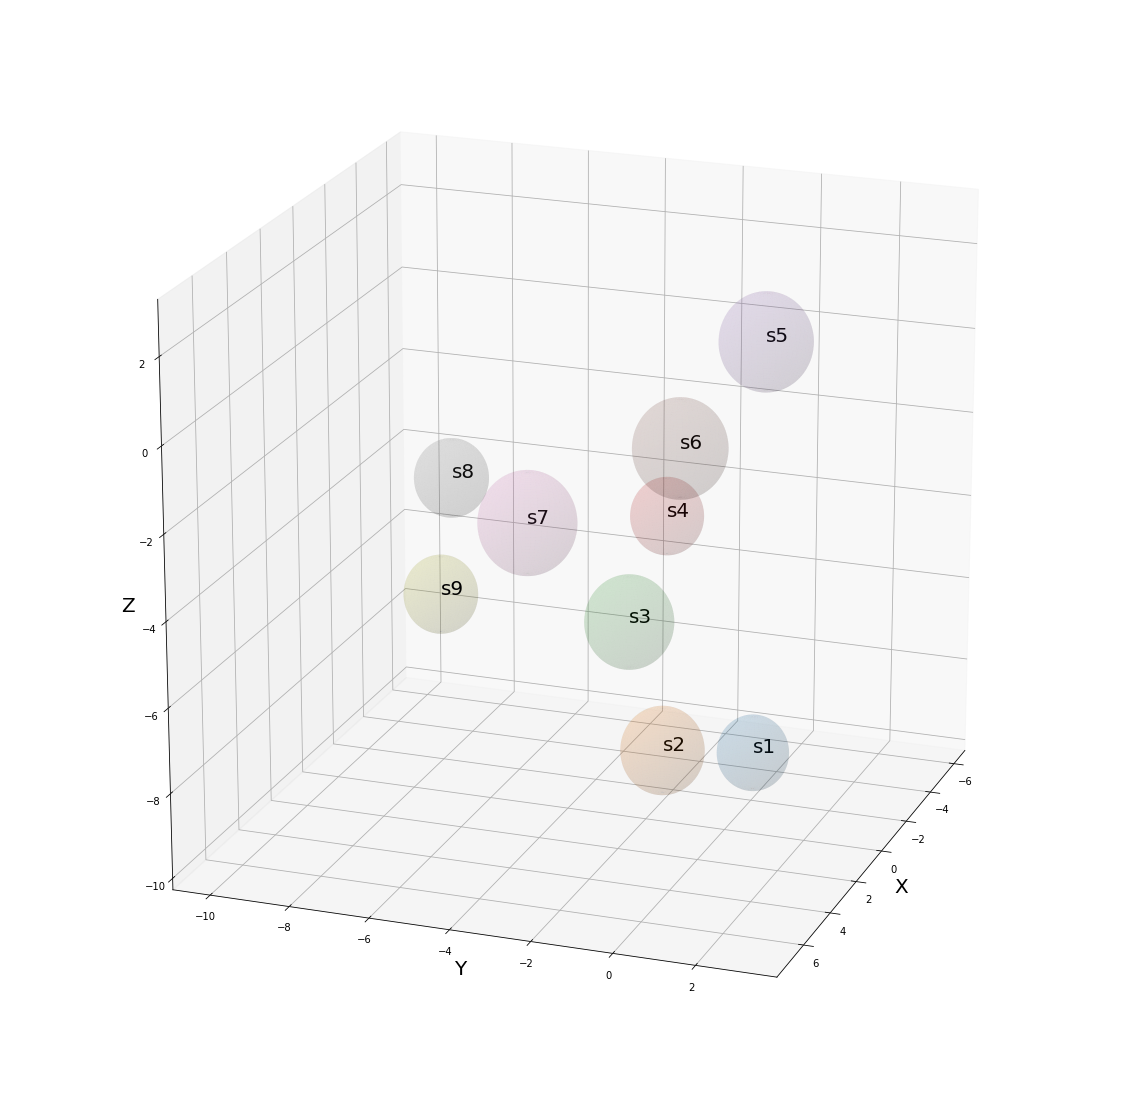

In [232]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

label_size = 20
ax.set_xlabel('X', size=label_size)
ax.set_ylabel('Y', size=label_size)
ax.set_zlabel('Z', size=label_size)
fig.set_size_inches(20, 20, forward=True)
ax.view_init(20, 20)

radius = r_max/10
for i in mono_dict:
#     ax.scatter(mono_dict[i].df_q['x'], mono_dict[i].df_q['y'], mono_dict[i].df_q['z'])
    center = [i/10 for i in centroids[i]]
    plot_sphere(ax, center, rad[i]/10.0)
    ax.text(center[0], center[1], center[2], i, fontsize=20)

X, Y, Z = np.array([-3, 4]), np.array([-10, 3]), np.array([-10, 3])
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')
    
fig.savefig('ns_bim_monomer_spheres/ns_bim_program_mab_D_2/charge_placement.png', bbox_inches='tight', dpi=300)